In [1]:
#%%writefile Cointegration.py
#https://medium.com/@bart.chr/pairs-trading-for-algorithmic-trading-breakdown-d8b709f59372
#https://github.com/aconstandinou/mean-reversion

import statsmodels.api as sm
import statsmodels.tsa.stattools as ts 
from statsmodels.tsa.stattools import coint
import numpy as np
import pandas as pd
import statistics

import matplotlib.pyplot as plt

# Functions/Methods

In [19]:
"""
Augmented Dickey–Fuller (ADF) unit root test; p-value < .05
"""
class DickeyFuller(object):
    def __init__(self, significance=.05):
        self.significance_level = significance
        self.p_value = None
        self.perc_stat = None
        self.is_stationary = None
        
    def check(self, time_series):
        model = ts.adfuller(time_series, 1)
        self.p_value = model[1]
        self.perc_stat = model[0]
        
        self.is_stationary = False
        if (self.p_value < self.significance_level):
            self.is_stationary = True
        return self.is_stationary;

"""
Half Life test from the Ornstein-Uhlenbeck process 
"""
class HalfLife(object):
    def __init__(self):
        self.half_life = None

    def check(self, time_series):
        lag = np.roll(time_series, 1)
        lag[0] = 0
        ret = time_series - lag
        ret[0] = 0

        # adds intercept terms to X variable for regression
        lag2 = sm.add_constant(lag)
        res = sm.OLS(ret, lag2).fit()
        self.half_life = int(round(-np.log(2) / res.params[1],0))

        if self.half_life <= 0:
            self.half_life = 1
        return self.half_life

"""
If Hurst Exponent is under the 0.5 value of a random walk, then the series is mean reverting
"""
class HurstExponent():
    def __init__(self):
        self.h_min = 0.0
        self.h_max = 0.4
        self.look_back = 126
        #https://robotwealth.com/demystifying-the-hurst-exponent-part-1/
        self.lag_max = 20#era 100
        self.h_value = None
    
    def check(self, time_series):
        lags = range(2, self.lag_max)

        tau = [np.sqrt(np.std(np.subtract(time_series[lag:], time_series[:-lag]))) for lag in lags]
        poly = np.polyfit(np.log(lags), np.log(tau), 1)

        self.h_value = poly[0]*2.0 
        return self.h_value

def model_ols(y, x):
    x = sm.add_constant(x)
    model = sm.OLS(y, x).fit()
    return model

# beta/coeficiente angular
def beta(y, x):
    model = model_ols(y, x)
    return model.params[1]

# check cointegrated pairs from dataframe
def find_cointegrated_pairs(data, num_pairs=0):
    adf = DickeyFuller()
    rows = []
    isBreak = False
    index=-1
    
    for y_symbol in data.columns:
        index = index + 1
        for x_symbol in data.columns[index+1:data.shape[1]]:#for x_symbol in data.columns:
            if (y_symbol == x_symbol):
                continue
            
            model = model_ols(data[y_symbol], data[x_symbol])
            adf.check(model.resid)
            beta = model.params[1]
            #if (adf.is_stationary):
            rows.append([y_symbol,x_symbol,adf.p_value, adf.perc_stat, beta])
                    
            # break for two
            isBreak = (num_pairs > 0 and len(rows) >= num_pairs)
            if (isBreak == True): break
        
        # break for one
        if (isBreak == True): break

    df_pairs = pd.DataFrame(rows, columns=['Dependente', 'Independente', 'pValue', 'ADFStatistic', 'Beta'])
    return df_pairs

def apply_periods(data, pairs):
    pairs['Period'] = 0
    pairs['PeriodStr'] = ''    
    for i, row in pairs.iterrows():
        y = data[row['Dependente']]
        x = data[row['Independente']]
        analysis = analysis_by_periods(y, x)
        stationary = analysis.loc[(analysis['Stationary'])]

        des = ''
        for j, row in stationary.iterrows():
            if (des!=''):
                des=des+','
            des=des+str(row['Period'])

        pairs['Period'].iloc[i] = stationary.shape[0]
        pairs['PeriodStr'].iloc[i] = des
        
def analysis_by_periods(y, x):
    rows=[]
    n = len(y)
    adf = DickeyFuller()
    
    for period in [100, 120, 140, 160, 180, 200, 220, 240, 250]:
        pos = n-period
        y_values = y.iloc[pos:]
        x_values = x.iloc[pos:]
        
        coin = cointegration(y_values, x_values, 0)
        half_life = check_halflife(y_values, x_values)
        hurst = check_hurst(y_values, x_values)
        corr = corr_pearson(y_values, x_values)
            
        rows.append([period, coin[0], coin[1], coin[1], coin[2], half_life, hurst, corr])
        
    analysis = pd.DataFrame(rows, columns=['Period', 'Stationary', 'pValue', 'ADFStatistic', 'Beta', 'HalfLife', 'Hurst', 'Corr'])
    return analysis

def cointegration(y, x, period = 0):
    adf = DickeyFuller()
    n = len(y)
    if (period > 0):
        pos = n-period
        y = y.iloc[pos:]
        x = x.iloc[pos:]
    else:
        period = n
        
    model = model_ols(y, x)
    adf.check(model.resid)
    return [adf.is_stationary, adf.p_value, adf.perc_stat, model.params[1], period]

def apply_halflife(data, pairs):
    pairs['HalfLife'] = 0
    
    for i, row in pairs.iterrows():
        y = data[row['Dependente']]
        x = data[row['Independente']]
        
        value = check_halflife(y, x)
        pairs['HalfLife'].iloc[i]=value

def check_halflife(y, x):
    halflile = HalfLife()
    model = model_ols(y, x)
    return halflile.check(model.resid)

def apply_hurst(data, pairs):
    pairs['Hurst'] = 0
    
    for i, row in pairs.iterrows():
        y = data[row['Dependente']]
        x = data[row['Independente']]
        
        value = check_hurst(y, x)
        pairs['Hurst'].iloc[i]= value

def check_hurst(y, x):
    hurst = HurstExponent()
    model = model_ols(y, x)
    return hurst.check(model.resid.values)

# 0.9 para mais ou para menos indica uma correlação muito forte.
# 0.7 a 0.9 positivo ou negativo indica uma correlação forte.percorre
# 0.5 a 0.7 positivo ou negativo indica uma correlação moderada.
# 0.3 a 0.5 positivo ou negativo indica uma correlação fraca.
# 0 a 0.3 positivo ou negativo indica uma correlação desprezível.'''
def corr_pearson(y, x):
    y_avg, x_avg = np.average(y), np.average(x)
    y_stdev, x_stdev = np.std(y), np.std(x)
    n = len(y)
    denominator = y_stdev * x_stdev * n
    numerator = np.sum(np.multiply(y-y_avg, x-x_avg))
    p_coef = numerator/denominator
    return p_coef

def apply_corr(data, pairs):
    pairs['Corr'] = 0
    
    for i, row in pairs.iterrows():
        y = data[row['Dependente']]
        x = data[row['Independente']]
        
        corr = corr_pearson(y, x)
        pairs['Corr'].iloc[i] = corr

def signal(y, x):
    model = model_ols(y, x)
    std = statistics.stdev(model.resid)
    resi_curr = model.resid.iloc[-1]
    zscore_up = 2*std
    zscore_down = -2*std
    zcurrent = 0
    desc = ''
    
    # >0; resíduo acima da linha 0
    if(resi_curr > 0):
        desc = 'SL'
        zcurrent = zscore_up
    else:
        desc = 'LS'
        zcurrent = zscore_down
    
    percent = (abs(resi_curr)/abs(zcurrent))
    #1-descr
    #2-resíduo atual
    #3-percent distância da linha 0, quanto maior, melhor
    return [desc, resi_curr, percent]

def apply_signal(data, pairs):
    pairs['Signal'] = 0
    pairs['SignalStr'] = ''    
    
    for i, row in pairs.iterrows():
        y = data[row['Dependente']]
        x = data[row['Independente']]

        sig = signal(y, x)
        pairs['Signal'].iloc[i] = sig[2]
        pairs['SignalStr'].iloc[i] = sig[0]        

def check_periods(data, y_symbol, x_symbol, period):
    if (type(period) is int):
        return check_oneperiod(data, y_symbol, x_symbol, period)
    if (type(period) is list):
        rows=[]
        for p in period:
            res = check_oneperiod(data, y_symbol, x_symbol, p)
            rows.append([res[0], res[1]])
        return rows

def check_oneperiod(data, y_symbol, x_symbol, period):
    y = data[y_symbol]
    x = data[x_symbol]
    
    if(period > 0):
        pos = data.shape[0]-period
        y = y.iloc[pos:]
        x = x.iloc[pos:]
    
    adf = DickeyFuller()
    model = model_ols(y, x)
    adf.check(model.resid)
    beta = model.params[1]

    return [adf.p_value, adf.is_stationary];

def show(data, y_symbol, x_symbol, period=0):
    y = data[y_symbol]
    x = data[x_symbol]
    
    if(period > 0):
        pos = data.shape[0]-period
        y = y.iloc[pos:]
        x = x.iloc[pos:]
    
    model= model_ols(y, x)
    std = statistics.stdev(model.resid)
    entry_threshold = 2 # entrada em 2 desvio padrão

    #plt.figure(figsize=(15,6))
    plt.figure(figsize=(10,5))
    plt.plot(model.resid)
    plt.ylabel('Residual')
    plt.title(y_symbol + ' / ' + x_symbol)

    plt.axhline(0, color='black',label='mean',linestyle='--') # Add the mean of residual
    plt.axhline(entry_threshold*std, color='green', linestyle='--',label='trade')
    plt.axhline(-entry_threshold*std, color='green', linestyle='--')

    plt.legend()
    plt.show()

## Read CSV

In [3]:
# todas as ações
#df = pd.read_csv('datasets/data.csv')

# somentes as ações que fazem parte da carteira ibovespa
df = pd.read_csv('datasets/data_cart.csv',index_col=0)#[['ABEV3', 'AZUL4', 'B3SA3', 'BBAS3', 'BBDC3']]

data = df[df.columns.difference(['Data'])]
data.shape

(355, 71)

In [317]:
pairs = find_cointegrated_pairs(data, 0)
pairs.head(3)

,Dependente,Independente,pValue,ADFStatistic,Beta
0,ABEV3,AZUL4,0.248276,-2.090687,0.152839
1,ABEV3,B3SA3,0.847264,-0.698009,0.058191
2,ABEV3,BBAS3,0.027352,-3.089339,0.264904


In [318]:
apply_halflife(data, pairs)
print('Half-Life applied successfully')

Half-Life applied successfully


In [319]:
apply_hurst(data, pairs)
print('Hurst applied successfully')

Hurst applied successfully


In [320]:
apply_corr(data, pairs)
print('Correlation applied successfully')

Correlation applied successfully


In [321]:
apply_signal(data, pairs)
print('Signal applied successfully')

Signal applied successfully


In [322]:
pairs.head(3)

,Dependente,Independente,pValue,ADFStatistic,Beta,HalfLife,Hurst,Corr,Signal,SignalStr
0,ABEV3,AZUL4,0.248276,-2.090687,0.152839,23,0.439056,0.853351,0.051128,SL
1,ABEV3,B3SA3,0.847264,-0.698009,0.058191,107,0.491236,0.154203,0.705434,LS
2,ABEV3,BBAS3,0.027352,-3.089339,0.264904,14,0.397299,0.875547,0.053038,LS


In [323]:
pairs.to_csv('datasets/cointegrated_pairs.csv', index=False)
print('Criado com sucesso!!!')

Criado com sucesso!!!


# Analysis

In [33]:
pairs = pd.read_csv('datasets/cointegrated_pairs.csv')
pairs.shape

(2485, 10)

In [325]:
df_hurst = pairs.loc[(pairs['Hurst'] > 0) & (pairs['Hurst'] < 0.4)]
df_hurst

,Dependente,Independente,pValue,ADFStatistic,Beta,HalfLife,Hurst,Corr,Signal,SignalStr
2,ABEV3,BBAS3,0.027352,-3.089339,0.264904,14,0.397299,0.875547,0.053038,LS
5,ABEV3,BBSE3,0.304453,-1.959844,0.453826,30,0.321713,0.739251,0.560796,LS
10,ABEV3,BRFS3,0.231443,-2.133027,0.268774,27,0.374320,0.770924,0.393191,LS
12,ABEV3,BRML3,0.476219,-1.613346,0.656802,38,0.352629,0.703001,0.285786,LS
14,ABEV3,CCRO3,0.644550,-1.266068,0.555108,63,0.326291,0.533061,0.668427,LS
...,...,...,...,...,...,...,...,...,...,...
2463,TIMP3,WEGE3,0.134937,-2.424513,0.155557,15,0.317630,0.805781,0.466036,LS
2467,TOTS3,VIVT4,0.000125,-4.606812,3.066138,7,0.293995,0.841575,1.042910,LS
2475,USIM5,VALE3,0.416301,-1.728874,0.260024,27,0.357497,0.608797,1.033873,LS
2482,VIVT4,VVAR3,0.446068,-1.671085,0.942055,26,0.317226,0.728812,1.834924,LS


In [350]:
corr = df_hurst.loc[(df_hurst['Corr'] >= 0.70)]
corr

,Dependente,Independente,pValue,ADFStatistic,Beta,HalfLife,Hurst,Corr,Signal,SignalStr
2,ABEV3,BBAS3,0.027352,-3.089339,0.264904,14,0.397299,0.875547,0.053038,LS
5,ABEV3,BBSE3,0.304453,-1.959844,0.453826,30,0.321713,0.739251,0.560796,LS
10,ABEV3,BRFS3,0.231443,-2.133027,0.268774,27,0.374320,0.770924,0.393191,LS
12,ABEV3,BRML3,0.476219,-1.613346,0.656802,38,0.352629,0.703001,0.285786,LS
21,ABEV3,CVCB3,0.030529,-3.049425,0.130914,17,0.374026,0.852861,0.009071,SL
...,...,...,...,...,...,...,...,...,...,...
2455,TAEE11,VVAR3,0.009807,-3.435487,0.526708,10,0.318325,0.887756,1.510351,LS
2462,TIMP3,VVAR3,0.102082,-2.557596,0.452459,13,0.334704,0.857833,0.894312,LS
2463,TIMP3,WEGE3,0.134937,-2.424513,0.155557,15,0.317630,0.805781,0.466036,LS
2467,TOTS3,VIVT4,0.000125,-4.606812,3.066138,7,0.293995,0.841575,1.042910,LS


#### Pares sinalizando entrada

In [341]:
signal = corr.loc[(df_hurst['Signal'] >= 0.95)].copy()
signal.reset_index(drop=True, inplace=True)
apply_periods(data, signal)

In [356]:
# somente pares cointegrados em no mínimo 3 períodos
signal.loc[(signal['Period'] > 2)].sort_values(by=['HalfLife'], ascending=True)

,Dependente,Independente,pValue,ADFStatistic,Beta,HalfLife,Hurst,Corr,Signal,SignalStr,Period,PeriodStr
62,LREN3,MULT3,0.000068,-4.750407,1.512641,5,0.250833,0.971247,1.438070,SL,6,"140,160,180,220,240,250"
74,TOTS3,VIVT4,0.000125,-4.606812,3.066138,7,0.293995,0.841575,1.042910,LS,7,"140,160,180,200,220,240,250"
65,QUAL3,VIVT4,0.000774,-4.158656,1.836992,7,0.257253,0.902282,1.088393,SL,8,"120,140,160,180,200,220,240,250"
58,IGTA3,LREN3,0.000744,-4.168615,1.050753,7,0.297478,0.961280,1.379036,LS,7,"120,140,160,180,200,220,250"
14,BBAS3,EMBR3,0.004834,-3.652426,1.923078,8,0.380021,0.953200,0.997803,SL,4,"200,220,240,250"
47,FLRY3,VIVT4,0.001561,-3.972651,0.787924,9,0.336699,0.879504,1.338015,SL,6,"160,180,200,220,240,250"
70,SULA11,VIVT4,0.001682,-3.952340,2.185313,11,0.322983,0.867586,1.101672,SL,5,"180,200,220,240,250"
57,HYPE3,VIVT4,0.006323,-3.571833,0.619796,11,0.356265,0.770722,1.234197,SL,8,"120,140,160,180,200,220,240,250"
41,ECOR3,VIVT4,0.001841,-3.927544,0.570259,11,0.280518,0.883544,1.553927,SL,6,"160,180,200,220,240,250"
0,AZUL4,BBSE3,0.037784,-2.970082,3.152524,13,0.354216,0.919744,1.167227,LS,9,"100,120,140,160,180,200,220,240,250"


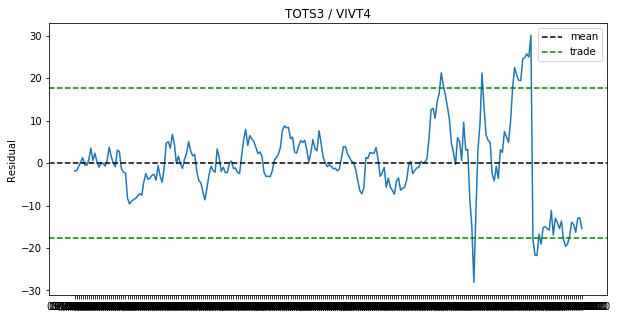

In [31]:
show(data, 'TOTS3', 'VIVT4', 250)

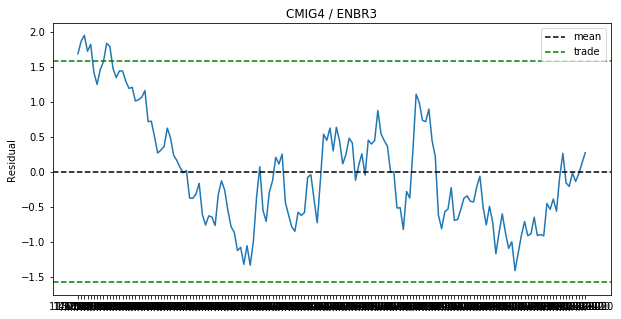

In [30]:
show(data, 'CMIG4', 'ENBR3', 160)

In [29]:
pos = data.shape[0]-160
y = data['CMIG4'].iloc[pos:]
x = data['ENBR3'].iloc[pos:]
model= model_ols(y, x)
std = statistics.stdev(model.resid)
print(std)

0.7888256063062328


In [8]:
analysis_by_periods(data['GOAU4'], data['GGBR4'])

,Period,Stationary,pValue,ADFStatistic,Beta,HalfLife,Hurst,Corr
0,100,True,0.000015,0.000015,-5.081955,2,0.138794,0.998512
1,120,True,0.000015,0.000015,-5.078872,2,0.148942,0.998182
2,140,True,0.000016,0.000016,-5.066071,2,0.171471,0.998035
3,160,True,0.000011,0.000011,-5.143498,2,0.191724,0.997716
4,180,True,0.002125,0.002125,-3.887947,3,0.192996,0.996930
5,200,True,0.008327,0.008327,-3.487004,5,0.201981,0.994993
6,220,False,0.052782,0.052782,-2.840009,7,0.218745,0.993827
7,240,False,0.052352,0.052352,-2.843287,7,0.241337,0.993742
8,250,True,0.042297,0.042297,-2.927002,7,0.240031,0.993735


In [35]:
pos = df.shape[0]-160

In [39]:
df['ENBR3'].iloc[pos:]

Data
11/10/2019    18.94
14/10/2019    18.75
15/10/2019    18.69
16/10/2019    18.87
17/10/2019    18.85
              ...  
01/06/2020    17.57
02/06/2020    17.95
03/06/2020    17.97
04/06/2020    17.72
05/06/2020    17.80
Name: ENBR3, Length: 160, dtype: float64